In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math
import datetime as dt

# Import data

## 1. plot_summaries.txt

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [145]:
#with open('data/MovieSummaries/plot_summaries.txt', encoding='utf8') as f:
#    lines = f.read()
#    print(lines)
    

################################ Balth: J'ai des problèmes avec les lignes en dessus...

colnames = ['Wikipedia_movie_ID', 'Summary'] 

df = pd.read_csv('data/MovieSummaries/plot_summaries.txt', names = colnames, header = None, sep="\t", on_bad_lines='warn')
df


,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


## 2. corenlp_plot_summaries.tar.gz [628 M, separate download]

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

In [146]:
## Reading the data inside the xml.gz file to a variable under the name data
#import gzip
#path_corenlp = 'data/corenlp_plot_summaries/'
#fname = '330.xml.gz'
#with gzip.open(path_corenlp+fname, 'rb') as f:
#    data = f.read()
#    
## Passing the stored data inside the beautifulsoup parser 
#bs_data = BeautifulSoup(data, "xml") 
#
## Finding all instances of tag   
#b_unique = bs_data.find_all("lemma") 
#print(b_unique) 

## 3. movie.metadata.tsv.gz [3.4 M]


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [147]:
#import data
colnames = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries' , 'Movie_genres'] 


movie_md_raw = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t',names = colnames, header=None)
movie_md = movie_md_raw.copy()
#rename the column
movie_md.rename(columns = {'Movie_box office_revenue':'Movie_boxoffice_revenue'}, inplace = True)
movie_md.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_boxoffice_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
68866,35333475,/m/0j9nnk_,Jaanu,2012-06-01,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A..."
32227,4791383,/m/0cnhk9,Princess Daisy,1983-11-06,NaN,190.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01lrrt"": ""Melodrama"", ""/m/07s9rl0"": ""Drama""}"
74594,6614498,/m/0gdtvw,Bloodfist VI: Ground Zero,1995-01-31,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio..."
36161,27777973,/m/0cc9hhb,Seven Seas to Calais,1962-12-21,2250000.0,102.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/03k9fj"": ""Adventure""}"
33959,28553837,/m/0czc09f,Among the Cinders,1983,NaN,104.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama""}"


**General description of data**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Wikipedia_movie_ID       81741 non-null  int64  
 1   Freebase_movie_ID        81741 non-null  object 
 2   Movie_name               81741 non-null  object 
 3   Movie_release_date       74839 non-null  object 
 4   Movie_boxoffice_revenue  8401 non-null   float64
 5   Movie_runtime            61291 non-null  float64
 6   Movie_languages          81741 non-null  object 
 7   Movie_countries          81741 non-null  object 
 8   Movie_genres             81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


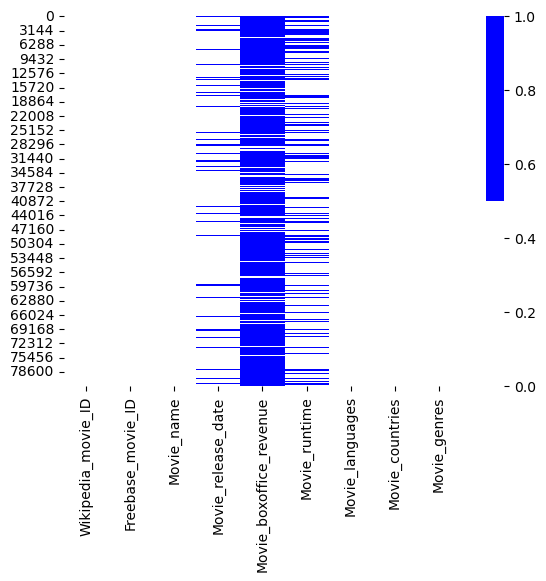

In [148]:
movie_md.info()
sns.heatmap(movie_md.isnull(), cmap=['w','b'])
plt.show()

**Create relational tables for languages, countries and genres**

In [149]:
def string2list(string):
    '''
    Converts string to dictionnary to list
    in order to be able to use pandas.DataFrame.explode()
    '''
    import ast
    
    dic = ast.literal_eval(string)
    new_list  = list(dic.values())
    return new_list


movie_languages = movie_md.copy()
movie_languages.Movie_languages = movie_languages.Movie_languages.apply(lambda x: string2list(x))
movie_languages = movie_languages.explode('Movie_languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_countries'\
                                                ,'Movie_genres'])
movie_languages['Movie_languages']= movie_languages['Movie_languages'].astype(str) 

movie_countries = movie_md.copy()
movie_countries['Movie_countries'] = movie_countries['Movie_countries'].apply(lambda x: string2list(x))
movie_countries = movie_countries.explode('Movie_countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_languages'\
                                                ,'Movie_genres'])

movie_genres = movie_md.copy()
movie_genres['Movie_genres'] = movie_genres['Movie_genres'].apply(lambda x: string2list(x))
movie_genres = movie_genres.explode('Movie_genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['Freebase_movie_ID', 'Movie_name','Movie_release_date'\
                                                ,'Movie_boxoffice_revenue','Movie_runtime','Movie_languages'\
                                                ,'Movie_countries'])
movie_genres

,Wikipedia_movie_ID,Movie_genres
0,975900,Thriller
1,975900,Science Fiction
2,975900,Horror
3,975900,Adventure
4,975900,Supernatural
...,...,...
245618,913762,Drama
245619,12476867,Thriller
245620,12476867,Horror
245621,12476867,Slasher


**Clean + distribution of Movie_release_date**

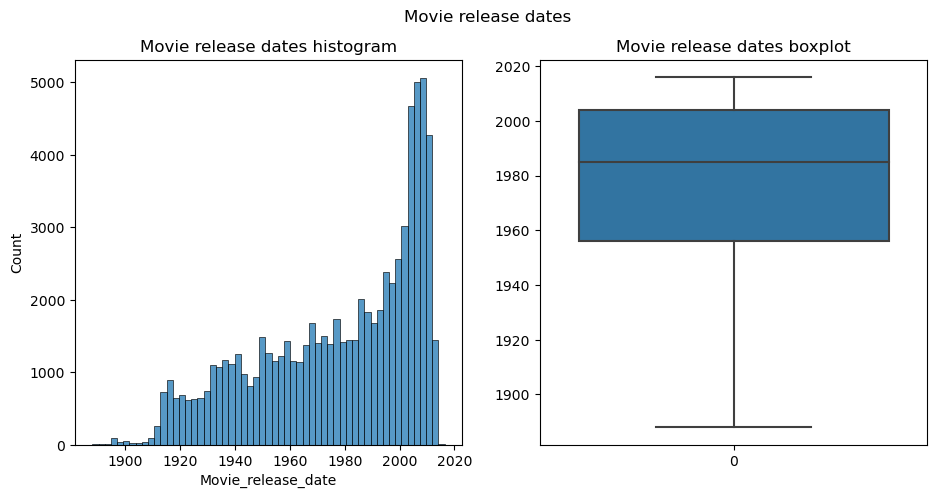

count                            74838
mean     1977-10-12 11:46:07.610037696
min                1888-01-01 00:00:00
25%                1956-01-01 00:00:00
50%                1985-05-18 12:00:00
75%                2004-01-01 00:00:00
max                2016-06-08 00:00:00
Name: Movie_release_date, dtype: object

In [150]:
#movie_md[movie_md.Movie_release_date.isna()]#all missing Movie_release_date are nan

#convert dates to datetimes. Dates with only year are set as the first of January of that year. Date that are out of bounds
#are set as NaT.
movie_md.Movie_release_date = pd.to_datetime(movie_md.Movie_release_date, errors = 'coerce', yearfirst = True)

plt.figure(figsize=[11, 5])
plt.suptitle('Movie release dates')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_release_date')
plt.title('Movie release dates histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=movie_md.Movie_release_date.dt.year)
plt.title('Movie release dates boxplot')
plt.show()

movie_md.Movie_release_date.describe(datetime_is_numeric = True)

There doesn't seem to be any major issues with the movie release dates. Although the earliest movie from the dataset is from 1888 (which raised suspicion) and lasts only 3 seconds, after some research, it is in fact a real 'film'.

**Clean + distribution of Movie_boxoffice_revenue**

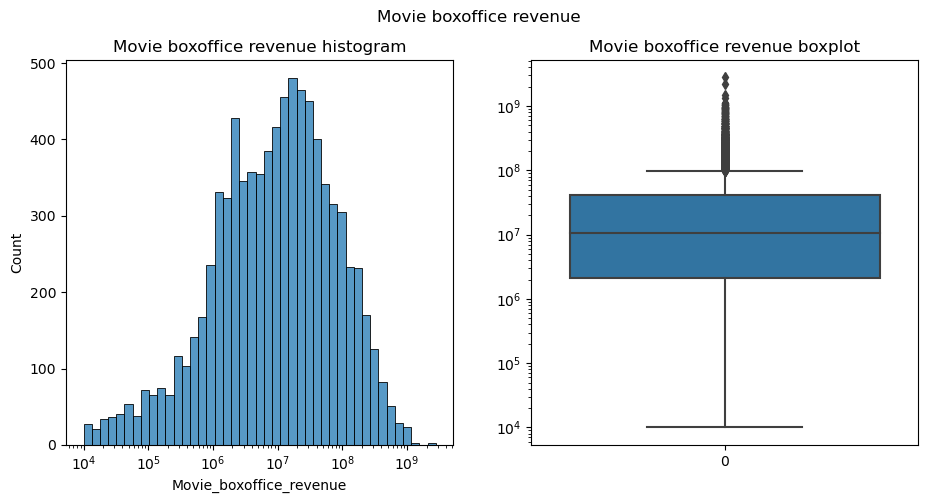

Max revenue: count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: Movie_boxoffice_revenue, dtype: float64


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_boxoffice_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [151]:
#movie_md[movie_md.Movie_boxoffice_revenue.isna()]#all missing Movie_release_date are nan

plt.figure(figsize=[11, 5])
plt.suptitle('Movie boxoffice revenue')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_boxoffice_revenue',log_scale = True)
plt.title('Movie boxoffice revenue histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=movie_md.Movie_boxoffice_revenue)
plt.yscale('log')
plt.title('Movie boxoffice revenue boxplot')
plt.show()

stats = movie_md.Movie_boxoffice_revenue.describe()
print(f'Max revenue: {stats}')
movie_md.loc[movie_md.Movie_boxoffice_revenue == stats[7]]#highest movie boxoffice is real, not 'dirty data' 

**Clean + distribution of Movie_runtime**

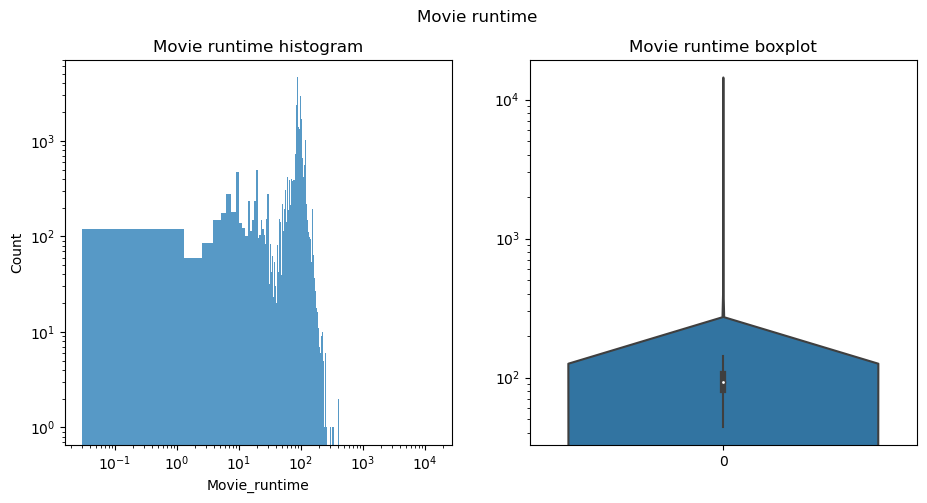

count    61289.000000
mean        94.213130
std         91.297088
min          0.030000
25%         81.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Movie_runtime, dtype: float64

In [152]:
#movie_md[movie_md.Movie_runtime.isna()]#all missing Movie_release_date are nan

#replace the max and min movie runtime which are wrong values.
movie_md.loc[movie_md.Movie_runtime == np.max(movie_md.Movie_runtime), 'Movie_runtime'] = np.nan #wrong max 
movie_md.loc[movie_md.Movie_runtime == np.min(movie_md.Movie_runtime), 'Movie_runtime'] = np.nan #wrong min

plt.figure(figsize=[11, 5])
plt.suptitle('Movie runtime')

# Plot 1
plt.subplot(1, 2, 1)
sns.histplot(data=movie_md, x='Movie_runtime')
plt.yscale('log')
plt.xscale('log')
plt.title('Movie runtime histogram')

# Plot 2
plt.subplot(1, 2, 2)
sns.violinplot(data=movie_md.Movie_runtime)
plt.yscale('log')
plt.title('Movie runtime boxplot')
plt.show()

movie_md.Movie_runtime.describe()

stats = movie_md.Movie_runtime.describe()
stats

**Clean + distributions of movie_languages**

In [153]:
#One problematic false movie language:'\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32' that still
#has to be dealt with. The lines below are just some tests that were done to try an resolve the issue, withou success

unique = pd.DataFrame(movie_languages.Movie_languages.unique())
unique
#From the line above, problematic language value: \ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32
#unique.loc[unique == 'English Language']
#unique[unique[0] == '\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32']
#'utf-8' codec can't encode characters in position 97-108: surrogates not allowed
#oui = unique == '\ud801\udc16\ud801\udc32\ud801\udc49\ud801\udc4b\ud801\udc4c\ud801\udc32'

#non = oui[0].tolist()
#non.index(True)
#unique.iloc[82]

,0
0,English Language
1,Norwegian Language
2,German Language
3,Silent film
4,Spanish Language
...,...
203,Chewa language
204,Haryanvi Language
205,Assyrian language
206,Papiamento language


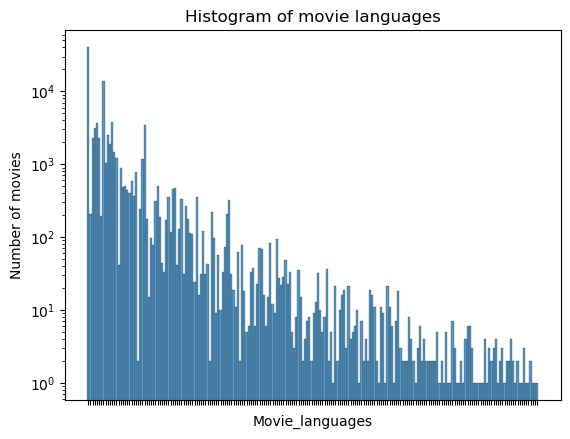

,Number_movies,Ratio,Cumsum
Movie_languages,,,
English Language,40891,42.965368,42.965368
nan,13866,14.569411,57.534779
Hindi Language,3744,3.933930,61.468709
Spanish Language,3673,3.859328,65.328038
French Language,3422,3.595595,68.923633
...,...,...,...
Picard Language,1,0.001051,99.995797
Sunda Language,1,0.001051,99.996848
Sumerian,1,0.001051,99.997899


In [154]:
#histogram of all movie languages (without labels as unreadable otherwise)
plt.figure()
g = sns.histplot(data=movie_languages, x='Movie_languages')
g.set(xticklabels=[])
g.set_title('Histogram of movie languages')
g.set_ylabel('Number of movies')
plt.yscale('log')
plt.show()

#make sorted table of movie languages with the number of movies in that language, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_languages_sorted = movie_languages.groupby(by = 'Movie_languages').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_languages_sorted = number_movie_languages_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_languages = number_movie_languages_sorted.sum()
number_movie_languages_sorted['Ratio'] = number_movie_languages_sorted*100/tot_movies_languages
number_movie_languages_sorted['Cumsum'] = number_movie_languages_sorted['Ratio'].cumsum()

number_movie_languages_sorted

**Clean + distributions of movie_countries**

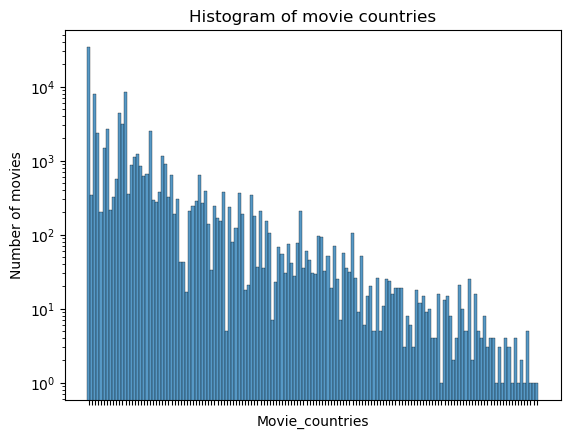

,Number_movies,Ratio,Cumsum
Movie_countries,,,
United States of America,34408,39.806106,39.806106
India,8411,9.730561,49.536667
United Kingdom,7868,9.102373,58.639040
France,4395,5.084510,63.723551
Italy,3163,3.659228,67.382779
...,...,...,...
Ukranian SSR,1,0.001157,99.995372
Iraqi Kurdistan,1,0.001157,99.996529
Macau,1,0.001157,99.997686


In [155]:
movie_countries.Movie_countries.unique()

#histogram of all movie countries (without labels as unreadable otherwise)
plt.figure()
g = sns.histplot(data=movie_countries, x='Movie_countries')
g.set(xticklabels=[])
g.set_title('Histogram of movie countries')
g.set_ylabel('Number of movies')
plt.yscale('log')
plt.show()

#make sorted table of movie countires with the number of movies from that country, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_countries_sorted = movie_countries.groupby(by = 'Movie_countries').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_countries_sorted = number_movie_countries_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_countries = number_movie_countries_sorted.sum()

number_movie_countries_sorted['Ratio'] = number_movie_countries_sorted*100/tot_movies_countries
number_movie_countries_sorted['Cumsum'] = number_movie_countries_sorted['Ratio'].cumsum()

number_movie_countries_sorted

**Clean + distributions of movie_genres**

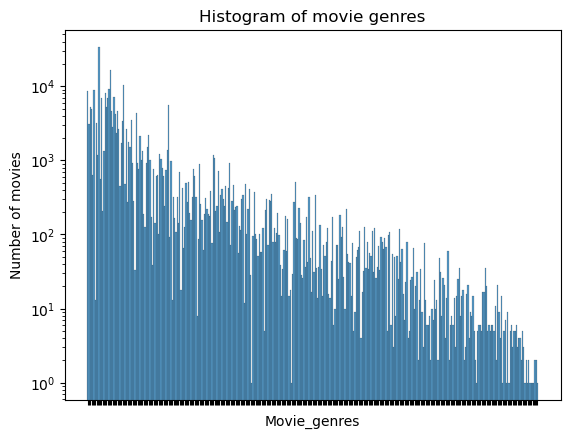

,Number_movies,Ratio,Cumsum
Movie_genres,,,
Drama,34007,13.975728,13.975728
Comedy,16349,6.718887,20.694615
Romance Film,10234,4.205828,24.900443
Black-and-white,9094,3.737327,28.637770
Action,8798,3.615681,32.253451
...,...,...,...
Comdedy,1,0.000411,99.998356
New Queer Cinema,1,0.000411,99.998767
Linguistics,1,0.000411,99.999178


In [156]:
movie_genres.Movie_genres.unique()

#replace Biopic [feature] by Biopic
movie_genres.loc[movie_genres.Movie_genres == 'Biopic [feature]','Movie_genres'] = 'Biopic'

#histogram of all movie genres (without labels as unreadable otherwise)
plt.figure()
g = sns.histplot(data=movie_genres, x='Movie_genres')
g.set(xticklabels=[])
plt.yscale('log')
g.set_title('Histogram of movie genres')
g.set_ylabel('Number of movies')
plt.show()

#make sorted table of movie genres with the number of movies from that genre, it's propotion relative to the other
#movies + cumulative proportion (cumsum)
number_movie_genres_sorted = movie_genres.groupby(by = 'Movie_genres').count().sort_values(
                                                            by = 'Wikipedia_movie_ID', ascending = False)
number_movie_genres_sorted = number_movie_genres_sorted.rename(columns = {'Wikipedia_movie_ID': 'Number_movies'})
tot_movies_genres = number_movie_genres_sorted.sum()

number_movie_genres_sorted['Ratio'] = number_movie_genres_sorted*100/tot_movies_genres
number_movie_genres_sorted['Cumsum'] = number_movie_genres_sorted['Ratio'].cumsum()
number_movie_genres_sorted

## 4. character.metadata.tsv.gz

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [157]:
colnames=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name','Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID'] 

character_md = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t',names = colnames, header=None)
character_md.head(5)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Data cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia_movie_ID               450669 non-null  int64  
 1   Freebase_movie_ID                450669 non-null  object 
 2   Movie_release_date               440674 non-null  object 
 3   Character_name                   192794 non-null  object 
 4   Actor_date_of_birth              344524 non-null  object 
 5   Actor_gender                     405060 non-null  object 
 6   Actor_height                     154824 non-null  float64
 7   Actor_ethnicity                  106058 non-null  object 
 8   Actor_name                       449441 non-null  object 
 9   Actor_age_at_movie_release       292556 non-null  float64
 10  Freebase_character/actor_map_ID  450669 non-null  object 
 11  Freebase_character_ID            192804 non-null  object 
 12  Fr

<AxesSubplot:>

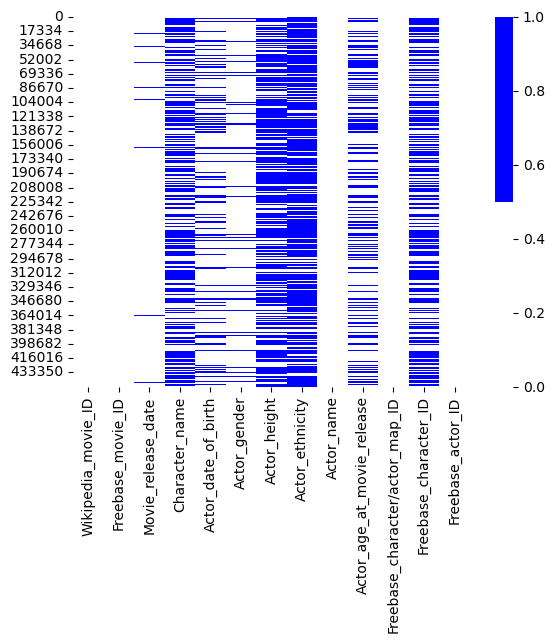

In [158]:
character_md.info()
sns.heatmap(character_md.isnull(),cmap=['w','b'])

In [159]:
print(f'There are {len(character_md)} rows')
for i in range(0,len(character_md.columns)):
    nans = character_md.iloc[:,i].isnull().sum()
    print(f'Column {character_md.columns[i]} has: \n\t {nans} NaNs \n \t {nans/len(character_md)*100}% of the rows with NaN')

There are 450669 rows
Column Wikipedia_movie_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN
Column Freebase_movie_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN
Column Movie_release_date has: 
	 9995 NaNs 
 	 2.217813961022391% of the rows with NaN
Column Character_name has: 
	 257875 NaNs 
 	 57.22048776374679% of the rows with NaN
Column Actor_date_of_birth has: 
	 106145 NaNs 
 	 23.552762670607475% of the rows with NaN
Column Actor_gender has: 
	 45609 NaNs 
 	 10.120287838746398% of the rows with NaN
Column Actor_height has: 
	 295845 NaNs 
 	 65.64573999986688% of the rows with NaN
Column Actor_ethnicity has: 
	 344611 NaNs 
 	 76.46654196317031% of the rows with NaN
Column Actor_name has: 
	 1228 NaNs 
 	 0.2724837963117055% of the rows with NaN
Column Actor_age_at_movie_release has: 
	 158113 NaNs 
 	 35.08406391387027% of the rows with NaN
Column Freebase_character/actor_map_ID has: 
	 0 NaNs 
 	 0.0% of the rows with NaN
Column Freebase_character_ID has: 
	 257865 NaNs 
 	 

For the gender analysis, we create a dataset that discards rows containing NaN for 'Actor_gender' 

In [160]:
character_md_gender = character_md[character_md['Actor_gender'].notna()]
print(f'{character_md.iloc[:,5].isnull().sum()} rows are discarded.\n This corresponds to {character_md.iloc[:,5].isnull().sum()/len(character_md)*100}% of the rows')

45609 rows are discarded.
 This corresponds to 10.120287838746398% of the rows


In [161]:
#take out "unnecessary" columns for the moment
character_gender = character_md_gender.copy()
#character_gender = character_gender[['Wikipedia_movie_ID',
#                                       'Movie_release_date','Character_name',
#                                       'Actor_gender','Actor_name']]
character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Some numbers and statistics

In [162]:
nb_women = character_gender[character_gender.Actor_gender == 'F'].shape[0]
nb_women
print(f'{nb_women/len(character_gender)*100}% of all the actors of the dataset are women')

33.27976102305831% of all the actors of the dataset are women


In [163]:
#convert to datetime type
character_gender['Movie_release_date'] = pd.to_datetime(character_gender['Movie_release_date'], errors = 'coerce')

In [164]:
character_gender.dtypes

Wikipedia_movie_ID                          int64
Freebase_movie_ID                          object
Movie_release_date                 datetime64[ns]
Character_name                             object
Actor_date_of_birth                        object
Actor_gender                               object
Actor_height                              float64
Actor_ethnicity                            object
Actor_name                                 object
Actor_age_at_movie_release                float64
Freebase_character/actor_map_ID            object
Freebase_character_ID                      object
Freebase_actor_ID                          object
dtype: object

In [165]:
#create new column only with movie_release_year
character_gender['Movie_year'] = character_gender['Movie_release_date'].dt.year#.fillna(0.0).astype(int)
#character_gender = character_gender[character_gender.Movie_year != 0]
#df[list("ABCD")] = df[list("ABCD")].fillna(0.0).astype(int)
character_gender.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


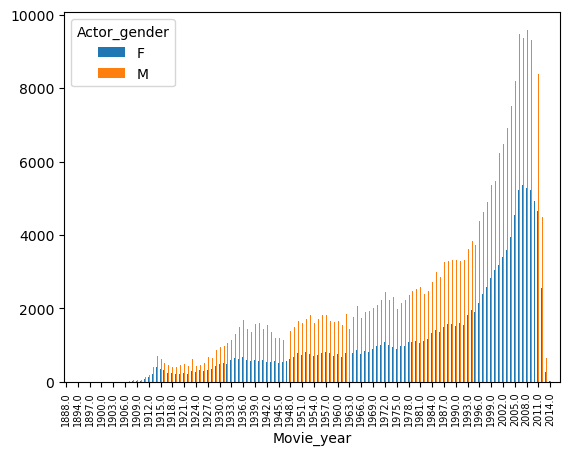

In [166]:
character_gender.pivot_table(index=['Movie_year'],columns='Actor_gender',aggfunc='size').plot(kind='bar')
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::3])
ax.xaxis.set_tick_params(labelsize=7)

## tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

First of all, the text document is read into a dataframe with tabstop as separator. Further manipulations are performed in order to have a well-arranged dataframe including all necessary information.

In [167]:
# create dataframe by reading the textfile with tabstop as separator
colnames = ['character_type', 'description'] 

df_tvtropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt',
                          names = colnames, header = None, sep="\t", on_bad_lines='warn')

In [168]:
# split column "description" of the df in further columns "char", "movie", "id", and "actor"
df_tvtropes.description=df_tvtropes['description'].str.replace("{" ,"",regex=True)
df_tvtropes.description=df_tvtropes['description'].str.replace("}" ,"",regex=True)
#df_tvtropes.description=df_tvtropes['description'].str.replace('"' ,'',regex=True)
#df_tvtropes.description=df_tvtropes['description'].str.replace(' ' ,'',regex=True)

# new data frame with split value columns
new = df_tvtropes["description"].str.split('", "|": "', expand=True)
 
# add to existing dataframe
df_tvtropes["char"]= new[1]
df_tvtropes["movie"]= new[3]
df_tvtropes["id"]=new[5]
df_tvtropes["actor"]=new[7]

df_tvtropes['actor']=df_tvtropes['actor'].str.replace('"' ,'',regex=True)
 
# Drop old column "description"
df_tvtropes.drop(columns =["description"], inplace = True)

# Merge with Character Metadata to get gender of actor
df_tvtropes = pd.merge(df_tvtropes, character_md[['Freebase_character/actor_map_ID','Actor_gender']],
                       left_on='id', right_on='Freebase_character/actor_map_ID', how='left')
 
# display df
df_tvtropes

,character_type,char,movie,id,actor,Freebase_character/actor_map_ID,Actor_gender
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,/m/0jy9q0,M
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,/m/02vchl3,M
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,/m/0k6fkc,M
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,/m/0k6_br,M
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,/m/0k3rhh,M
...,...,...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton,/m/0k776f,M
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,/m/0k2kqg,M
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West,/m/0k5nsh,M
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez,/m/03lrjk0,M


In [169]:
# check if there is any NaN value
df_tvtropes.isnull().any()

character_type                     False
char                               False
movie                              False
id                                 False
actor                              False
Freebase_character/actor_map_ID    False
Actor_gender                        True
dtype: bool

The dataframe is grouped by character types in order to investigate the most prevalent types.

In [170]:
df_tvtropes_grouped = df_tvtropes.groupby(['character_type'])['character_type'].count().\
                        to_frame(name='nb_movies').reset_index()
df_tvtropes_grouped = df_tvtropes_grouped.sort_values(by='nb_movies', ascending=False).reset_index()
df_tvtropes_grouped.drop(columns =["index"], inplace = True)

In [171]:
print('These are the 10 most prevalent character types:')
for i in range(10):
    print(f"{i+1}. {df_tvtropes_grouped['character_type'][i]} (in {df_tvtropes_grouped['nb_movies'][i]} movies)")

These are the 10 most prevalent character types:
1. crazy_jealous_guy (in 25 movies)
2. corrupt_corporate_executive (in 23 movies)
3. byronic_hero (in 17 movies)
4. psycho_for_hire (in 16 movies)
5. father_to_his_men (in 15 movies)
6. stoner (in 13 movies)
7. brainless_beauty (in 12 movies)
8. master_swordsman (in 12 movies)
9. dumb_blonde (in 11 movies)
10. slacker (in 11 movies)


For the analysis, the dataframe is divided into two dataframes. One conains all instances with a woman as an actress, the other one with men.

In [172]:
# create separate dfs by gender
df_tvtropes_M = df_tvtropes[df_tvtropes['Actor_gender']=='M']
df_tvtropes_F = df_tvtropes[df_tvtropes['Actor_gender']=='F']
print(f'Number of tvtropes for a female actor: {df_tvtropes_F.shape[0]}')
print(f'Number of tvtropes for a male actor: {df_tvtropes_M.shape[0]}')
print(f"Number of tvtropes where gender of actor/actress could not be identified:\
 {df_tvtropes[df_tvtropes['Actor_gender'].isnull()].shape[0]} -> this instance will not be considered for further analysis")

Number of tvtropes for a female actor: 69
Number of tvtropes for a male actor: 431
Number of tvtropes where gender of actor/actress could not be identified: 1 -> this instance will not be considered for further analysis


In [173]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [174]:
words_F = ' '.join(df_tvtropes_F['character_type'].values)
words_F = words_F.replace("_"," ")

words_M = ' '.join(df_tvtropes_M['character_type'].values)
words_M = words_M.replace("_"," ")

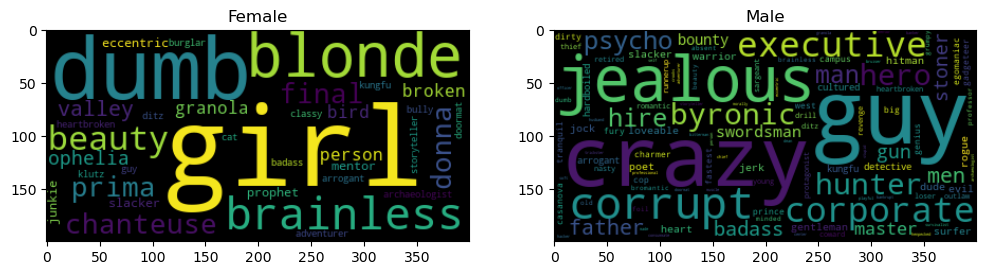

In [175]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud_F = WordCloud(collocations=False).generate(words_F)
wordcloud_M = WordCloud(collocations=False).generate(words_M)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))

ax1.imshow(wordcloud_F, interpolation="bilinear")
ax1.set_title('Female')
ax2.imshow(wordcloud_M, interpolation="bilinear")
ax2.set_title('Male');
#plt.show()

Use Empath to categorize words from above into lexical fields.

In [176]:
pip install empath

Note: you may need to restart the kernel to use updated packages.


In [177]:
from empath import Empath
lexicon = Empath()

In [178]:
'_'.join(df_tvtropes_F['character_type'].values).split('_'); # convert column of df into list of words

In [179]:
lexicon.analyze('_'.join(df_tvtropes_F['character_type'].values).split('_'), normalize=True); # test if it works

In [180]:
df_category = []
df_category.append(lexicon.analyze('_'.join(df_tvtropes_F['character_type'].values).split('_'), normalize=True))
df_category.append(lexicon.analyze('_'.join(df_tvtropes_M['character_type'].values).split('_'), normalize=True))

# transform into a dataframe
df_category = pd.DataFrame(df_category, index = ['Female','Male'])  
df_category

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Female,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.008197,...,0.000000,0.098361,0.000000,0.000000,0.0,0.0,0.0,0.049180,0.0,0.0
Male,0.0,0.0,0.0,0.003018,0.012072,0.0,0.0,0.0,0.0,0.033199,...,0.013078,0.028169,0.035211,0.009054,0.0,0.0,0.0,0.007042,0.0,0.0


In [181]:
df_category = df_category.loc[:, (df_category != 0).any(axis=0)] # delete lexical field with 0 for both F and M

In [182]:
df_category = df_category.copy().T
df_category

,Female,Male
money,0.000000,0.003018
wedding,0.000000,0.012072
hate,0.008197,0.033199
occupation,0.000000,0.064386
envy,0.000000,0.025151
...,...,...
weapon,0.000000,0.013078
children,0.098361,0.028169
monster,0.000000,0.035211
ocean,0.000000,0.009054


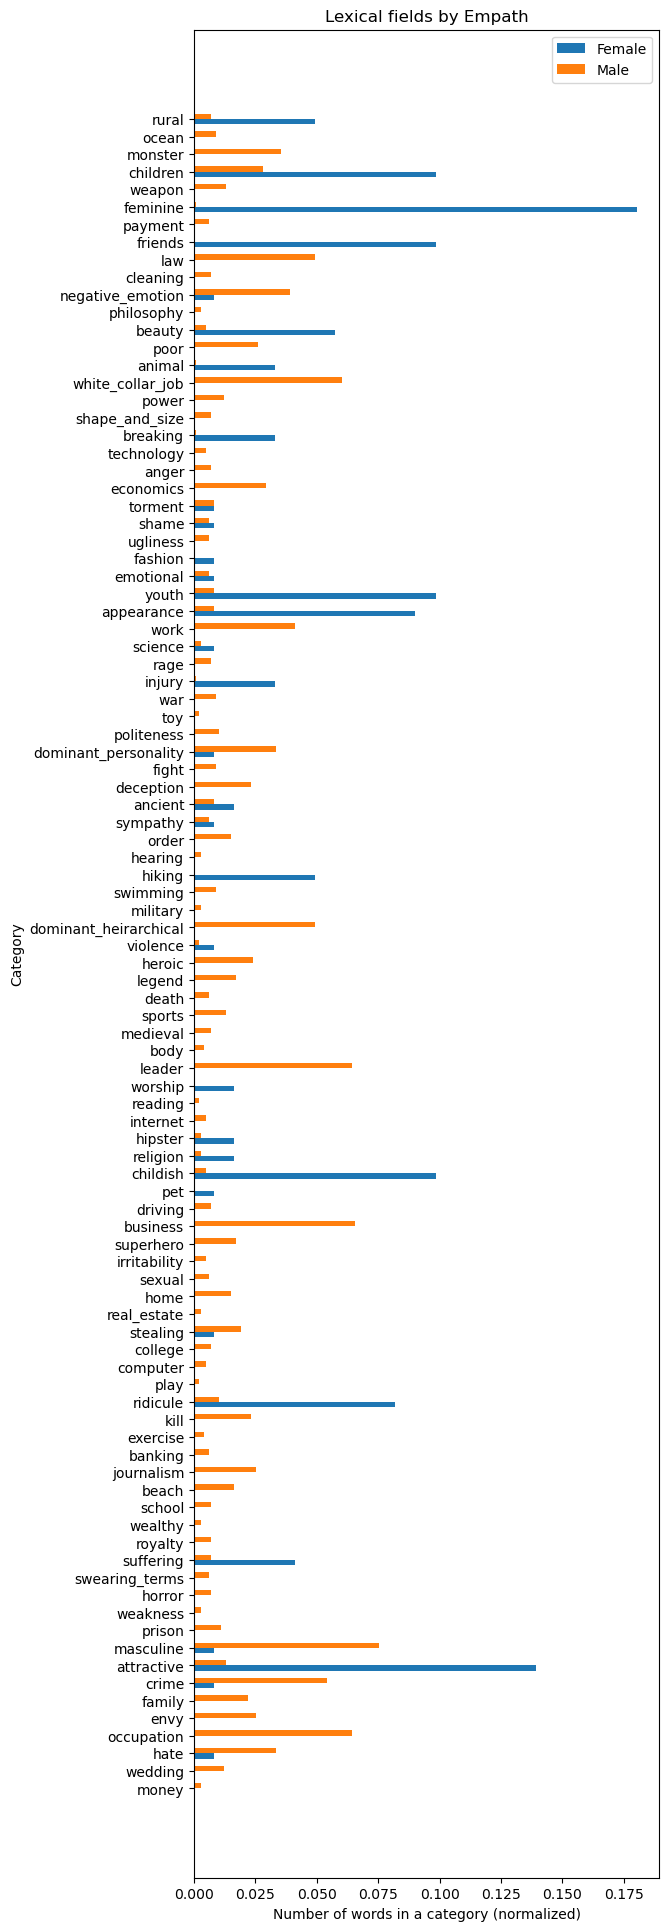

In [183]:
x = np.arange(df_category.shape[0])  # the label locations
new_x = [5*i for i in x]
new_x = np.asanyarray(new_x)
width = 1.5  # the width of the bars

fig, ax = plt.subplots(figsize=(6,24))
rects1 = ax.barh(new_x - width/2, df_category['Female'], width, align='center', label='Female')
rects2 = ax.barh(new_x + width/2, df_category['Male'], width, align='center', label='Male')
ax.set_ylabel('Category')
ax.set_xlabel('Number of words in a category (normalized)')
ax.set_title('Lexical fields by Empath')
ax.set_yticks(new_x, df_category.index)
ax.legend()

## name.clusters.txt


970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [184]:
# create dataframe by reading the textfile with tabstop as separator
colnames = ['character_name', 'freebase_movie_ID'] 

df_name_clusters = pd.read_csv('data/MovieSummaries/name.clusters.txt',
                          names = colnames, header = None, sep="\t", on_bad_lines='warn')
df_name_clusters

,character_name,freebase_movie_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
...,...,...
2661,John Rolfe,/m/0k5_ql
2662,John Rolfe,/m/02vd6vs
2663,Elizabeth Swann,/m/0k1xvz
2664,Elizabeth Swann,/m/0k1x_d


In [185]:
# verify if there are 970 unique character names
df_name_clusters["character_name"].unique().shape

(970,)

# Question 1.1

In [186]:
character_gender.head(5)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


**Number of males and females in each movie**

In [187]:
grouped_gender = character_gender.copy()
grouped_gender = grouped_gender[['Wikipedia_movie_ID','Actor_gender', 'Movie_year']]

#del grouped_gender['Character_name'], grouped_gender['Actor_name'], grouped_gender['Movie_release_date']



#Count the number of female/male actors for each movie
grouped_gender_F = grouped_gender.loc[grouped_gender.Actor_gender == 'F']
grouped_gender_F_movie = grouped_gender_F.groupby(['Wikipedia_movie_ID','Movie_year']).count()
grouped_gender_F_movie = grouped_gender_F_movie.rename(columns = {'Actor_gender':'Female'}).sort_values(by = 'Movie_year')

grouped_gender_M = grouped_gender.loc[grouped_gender.Actor_gender == 'M']
grouped_gender_M_movie = grouped_gender_M.groupby(['Wikipedia_movie_ID','Movie_year']).count()
grouped_gender_M_movie = grouped_gender_M_movie.rename(columns = {'Actor_gender':'Male'}).sort_values(by = 'Movie_year')

#Merge the number of males and females for each movie
grouped_gender_movie = pd.merge(grouped_gender_F_movie, grouped_gender_M_movie, on = ['Wikipedia_movie_ID', 'Movie_year'], how = 'outer')
grouped_gender_movie = grouped_gender_movie.fillna(0)

#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_movie['Female_share'] = grouped_gender_movie.Female/(grouped_gender_movie.Female + grouped_gender_movie.Male)
grouped_gender_movie.head(5)


,,Female,Male,Female_share
Wikipedia_movie_ID,Movie_year,,,
1082508,1888.0,2.0,2.0,0.5
7669437,1894.0,1.0,0.0,1.0
807258,1896.0,3.0,0.0,1.0
4062042,1896.0,1.0,1.0,0.5
436308,1896.0,1.0,1.0,0.5


**Number of males and females cast per year**

,Female,Male,Female_share
Movie_year,,,
1888.0,2.0,2,0.500000
1891.0,0.0,1,0.000000
1893.0,0.0,2,0.000000
1894.0,1.0,3,0.250000
1895.0,0.0,1,0.000000
...,...,...,...
2012.0,2545.0,4502,0.361147
2013.0,281.0,643,0.304113
2014.0,15.0,21,0.416667


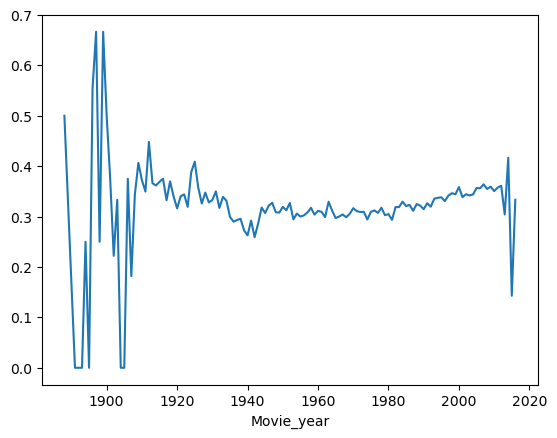

In [188]:
grouped_gender = character_gender.copy()
grouped_gender = grouped_gender[['Actor_gender', 'Movie_year']]

#Count the number of female/male actors for each year
grouped_gender_F = grouped_gender.loc[grouped_gender.Actor_gender == 'F']
grouped_gender_F_year = grouped_gender_F.groupby(['Movie_year']).count()
grouped_gender_F_year = grouped_gender_F_year.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = grouped_gender.loc[grouped_gender.Actor_gender == 'M']
grouped_gender_M_year = grouped_gender_M.groupby(['Movie_year']).count()
grouped_gender_M_year = grouped_gender_M_year.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each year
grouped_gender_year = pd.merge(grouped_gender_F_year, grouped_gender_M_year, on = ['Movie_year'], how = 'outer')
grouped_gender_year = grouped_gender_year.fillna(0)
grouped_gender_year = grouped_gender_year.sort_index()


#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_year['Female_share'] = grouped_gender_year.Female/(grouped_gender_year.Female + grouped_gender_year.Male)
grouped_gender_year['Female_share'].plot()

grouped_gender_year

**Adding countries**

In [189]:
grouped_gender = character_gender.copy()
grouped_gender = grouped_gender[['Wikipedia_movie_ID','Actor_gender','Movie_year']]


In [190]:
#merge with the dataset with countries, using movie_ID as common attribute
grouped_gender_country = pd.merge(grouped_gender, movie_countries, on = ['Wikipedia_movie_ID'], how = 'outer')
grouped_gender_country.head()

,Wikipedia_movie_ID,Actor_gender,Movie_year,Movie_countries
0,975900,F,2001.0,United States of America
1,975900,F,2001.0,United States of America
2,975900,M,2001.0,United States of America
3,975900,M,2001.0,United States of America
4,975900,F,2001.0,United States of America


In [191]:
del grouped_gender_country['Wikipedia_movie_ID'], grouped_gender_country['Movie_year']

#Count the number of female/male actors for each country
grouped_gender_F = grouped_gender_country.loc[grouped_gender_country.Actor_gender == 'F']
grouped_gender_F_country = grouped_gender_F.groupby(['Movie_countries']).count()
grouped_gender_F_country = grouped_gender_F_country.rename(columns = {'Actor_gender':'Female'})

grouped_gender_M = grouped_gender_country.loc[grouped_gender_country.Actor_gender == 'M']
grouped_gender_M_country = grouped_gender_M.groupby(['Movie_countries']).count()
grouped_gender_M_country = grouped_gender_M_country.rename(columns = {'Actor_gender':'Male'})

#Merge the number of males and females for each country
grouped_gender_country = pd.merge(grouped_gender_F_country, grouped_gender_M_country, on = ['Movie_countries'], how = 'outer')
grouped_gender_country = grouped_gender_country.fillna(0)

#Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_country['Female_share'] = grouped_gender_country.Female/(grouped_gender_country.Female + grouped_gender_country.Male)

In [192]:
grouped_gender_country=grouped_gender_country.reset_index()
grouped_gender_country.head()

,Movie_countries,Female,Male,Female_share
0,Afghanistan,23.0,34.0,0.403509
1,Albania,17.0,46.0,0.269841
2,Algeria,32.0,89.0,0.264463
3,Argentina,797.0,1503.0,0.346522
4,Armenia,8.0,11.0,0.421053


**Plot countries on a map with Female_share**

In [193]:
#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

In [194]:
#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

In [195]:
top_10 = number_movie_countries_sorted.head(10).reset_index()
top_10

,Movie_countries,Number_movies,Ratio,Cumsum
0,United States of America,34408,39.806106,39.806106
1,India,8411,9.730561,49.536667
2,United Kingdom,7868,9.102373,58.639040
3,France,4395,5.084510,63.723551
4,Italy,3163,3.659228,67.382779
5,Japan,2647,3.062275,70.445054
6,Canada,2534,2.931547,73.376601
7,Germany,2393,2.768426,76.145027
8,Argentina,1468,1.698307,77.843335
9,Hong Kong,1240,1.434538,79.277872


In [196]:
#keys=list(top_10.Movie_countries.values)
grouped_gender_country_10 = grouped_gender_country.copy()
#i1 = grouped_gender_country_10.set_index(keys).index
#i2 = top_10.set_index(keys).index
#grouped_gender_country_10 = grouped_gender_country_10[i1.isin(i2)]
top_10 = grouped_gender_country_10[(grouped_gender_country_10.Movie_countries.isin(top_10.Movie_countries))]
top_10

,Movie_countries,Female,Male,Female_share
3,Argentina,797.0,1503.0,0.346522
21,Canada,5476.0,9738.0,0.359932
40,France,8829.0,15547.0,0.362201
45,Germany,4984.0,10174.0,0.328803
48,Hong Kong,1973.0,4936.0,0.285570
51,India,15622.0,29872.0,0.343386
58,Italy,4700.0,9245.0,0.337038
60,Japan,4541.0,7948.0,0.363600
127,United Kingdom,15396.0,32386.0,0.322213
128,United States of America,72632.0,151461.0,0.324115


In [197]:
top_10['Country_code']='0'
for i in range(0,len(top_10)):
    top_10.iloc[i,4]=get_continent(top_10.iloc[i,0])[0]

C:\Users\Lara\AppData\Local\Temp\ipykernel_4548\663238235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Country_code']='0'


In [198]:
top_10

,Movie_countries,Female,Male,Female_share,Country_code
3,Argentina,797.0,1503.0,0.346522,AR
21,Canada,5476.0,9738.0,0.359932,CA
40,France,8829.0,15547.0,0.362201,FR
45,Germany,4984.0,10174.0,0.328803,DE
48,Hong Kong,1973.0,4936.0,0.285570,HK
51,India,15622.0,29872.0,0.343386,IN
58,Italy,4700.0,9245.0,0.337038,IT
60,Japan,4541.0,7948.0,0.363600,JP
127,United Kingdom,15396.0,32386.0,0.322213,GB
128,United States of America,72632.0,151461.0,0.324115,US


In [199]:
#Run the function above and split geolocate into two separate latitude and longitude columns
top_10[['Latitude','Longitude']]=[0,0]
for i in range(0,len(top_10)):
    top_10.iloc[i,5]=geolocate(top_10.iloc[i,4])[0]
    top_10.iloc[i,6]=geolocate(top_10.iloc[i,4])[1]

C:\Users\Lara\AppData\Local\Temp\ipykernel_4548\841568433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10[['Latitude','Longitude']]=[0,0]
C:\Users\Lara\AppData\Local\Temp\ipykernel_4548\841568433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10[['Latitude','Longitude']]=[0,0]
C:\Users\Lara\AppData\Local\Temp\ipykernel_4548\841568433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [200]:
top_10

,Movie_countries,Female,Male,Female_share,Country_code,Latitude,Longitude
3,Argentina,797.0,1503.0,0.346522,AR,-34.996496,-64.967282
21,Canada,5476.0,9738.0,0.359932,CA,61.066692,-107.991707
40,France,8829.0,15547.0,0.362201,FR,46.603354,1.888334
45,Germany,4984.0,10174.0,0.328803,DE,51.163818,10.447831
48,Hong Kong,1973.0,4936.0,0.285570,HK,22.350627,114.184916
51,India,15622.0,29872.0,0.343386,IN,22.351115,78.667743
58,Italy,4700.0,9245.0,0.337038,IT,42.638426,12.674297
60,Japan,4541.0,7948.0,0.363600,JP,36.574844,139.239418
127,United Kingdom,15396.0,32386.0,0.322213,GB,54.702354,-3.276575
128,United States of America,72632.0,151461.0,0.324115,US,39.783730,-100.445882


In [201]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(top_10)):
    lat = top_10.iloc[i]['Latitude']
    long = top_10.iloc[i]['Longitude']
    radius=np.exp(top_10.iloc[i,3]*10)
    popup_text = """Country : {}<br>
                 Share of female in movies: {}<br>"""
    popup_text = popup_text.format(top_10.iloc[i]['Country_code'],
                                   top_10.iloc[i]['Female_share'])
    folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

# Question 1.2

**Look at main movie producing countries trend: US, India, and UK**

In [202]:
top_3 = number_movie_countries_sorted.head(3).reset_index()
top_3

,Movie_countries,Number_movies,Ratio,Cumsum
0,United States of America,34408,39.806106,39.806106
1,India,8411,9.730561,49.536667
2,United Kingdom,7868,9.102373,58.639040


In [203]:
grouped_gender_country_10.head()

,Movie_countries,Female,Male,Female_share
0,Afghanistan,23.0,34.0,0.403509
1,Albania,17.0,46.0,0.269841
2,Algeria,32.0,89.0,0.264463
3,Argentina,797.0,1503.0,0.346522
4,Armenia,8.0,11.0,0.421053


In [204]:
top_3 = grouped_gender_country_10[(grouped_gender_country_10.Movie_countries.isin(top_3.Movie_countries))]
top_3

,Movie_countries,Female,Male,Female_share
51,India,15622.0,29872.0,0.343386
127,United Kingdom,15396.0,32386.0,0.322213
128,United States of America,72632.0,151461.0,0.324115


# Question 1.3

**Look at genres**

In [205]:
number_movie_genres_sorted

,Number_movies,Ratio,Cumsum
Movie_genres,,,
Drama,34007,13.975728,13.975728
Comedy,16349,6.718887,20.694615
Romance Film,10234,4.205828,24.900443
Black-and-white,9094,3.737327,28.637770
Action,8798,3.615681,32.253451
...,...,...,...
Comdedy,1,0.000411,99.998356
New Queer Cinema,1,0.000411,99.998767
Linguistics,1,0.000411,99.999178


In [206]:
genres_gender = pd.merge(movie_genres, character_gender, on = ['Wikipedia_movie_ID'], how = 'outer')
genres_gender = genres_gender[['Movie_genres','Actor_gender']]

In [207]:
#grouped_gender = character_gender.copy()
#del grouped_gender['Character_name'], grouped_gender['Actor_name'], grouped_gender['Movie_release_date'], grouped_gender['Wikipedia_movie_ID']
#
##Count the number of female/male actors for each year
grouped_gender_F = genres_gender.loc[genres_gender.Actor_gender == 'F']
grouped_gender_F_genres = grouped_gender_F.groupby(['Movie_genres']).count()
grouped_gender_F_genres = grouped_gender_F_genres.rename(columns = {'Actor_gender':'Female'})
#
grouped_gender_M = genres_gender.loc[genres_gender.Actor_gender == 'M']
grouped_gender_M_genres = grouped_gender_M.groupby(['Movie_genres']).count()
grouped_gender_M_genres = grouped_gender_M_genres.rename(columns = {'Actor_gender':'Male'})
#
##Merge the number of males and females for each year
grouped_gender_genres = pd.merge(grouped_gender_F_genres, grouped_gender_M_genres, on = ['Movie_genres'], how = 'outer')
grouped_gender_genres = grouped_gender_genres.fillna(0)
grouped_gender_genres = grouped_gender_genres.sort_index()
#
##Create metric to compare the number of females with number of males (1: only females in the movie, 0: only males)
grouped_gender_genres['Female_share'] = grouped_gender_genres.Female/(grouped_gender_genres.Female + grouped_gender_genres.Male)
grouped_gender_genres.sort_values(by='Female_share',ascending=False).head(60)

,Female,Male,Female_share
Movie_genres,,,
Romantic thriller,1.0,0.0,1.000000
Health & Fitness,12.0,6.0,0.666667
War effort,2.0,1.0,0.666667
Women in prison films,64.0,39.0,0.621359
Pinku eiga,44.0,28.0,0.611111
C-Movie,12.0,8.0,0.600000
Gender Issues,57.0,41.0,0.581633
Race movie,4.0,3.0,0.571429
Family & Personal Relationships,8.0,6.0,0.571429


# Question 2

In [208]:
#Creation of dataframe to be used for question 2
actor = character_gender.copy()

#Keep only columns of interest
actor = actor[['Wikipedia_movie_ID', 'Movie_year', 'Actor_gender','Actor_ethnicity',
                                     'Actor_name', 'Actor_age_at_movie_release', 'Freebase_actor_ID']]

#Aggregate rows on actor_ID, perform various functions on the other columns
actor = actor.groupby(by = 'Freebase_actor_ID').agg({'Wikipedia_movie_ID': 'count', 
                                                     'Movie_year': 'min',
                                                     'Actor_gender' : pd.Series.mode,
                                                     'Actor_ethnicity' : pd.Series.mode,
                                                     'Actor_name' : pd.Series.mode,
                                                     'Actor_age_at_movie_release' : ['min','max']})

#Clean the dataframe: drop one level of columns and rename them. Add a career_length column
actor = actor.droplevel(level = [0], axis=1)
actor.columns = ['Movie_count', 'First_movie_year', 'Gender', 'Actor_ethnicity', 'Actor_name', 'Min_actor_age', 'Max_actor_age']
actor['Career_length'] = actor.Max_actor_age - actor.Min_actor_age + 1

#replace emply list [] (missing actor_ethnicity) with NaN
actor.Actor_ethnicity = actor.Actor_ethnicity.apply(lambda y: np.nan if len(y)==0 else y)
actor



,Movie_count,First_movie_year,Gender,Actor_ethnicity,Actor_name,Min_actor_age,Max_actor_age,Career_length
Freebase_actor_ID,,,,,,,,
/m/010p3,12,1998.0,M,/m/0xnvg,Adam Carolla,33.0,47.0,15.0
/m/010q36,1,1995.0,M,NaN,Fred Rogers,67.0,67.0,1.0
/m/010wx,1,2003.0,F,/m/03q819,Aria Giovanni,25.0,25.0,1.0
/m/010xjr,54,1959.0,M,/m/03bkbh,Richard Harris,28.0,72.0,45.0
/m/0112yl,48,1948.0,M,NaN,Toshiro Mifune,28.0,69.0,42.0
...,...,...,...,...,...,...,...,...
/m/0z58,1,1998.0,M,NaN,Ardal O'Hanlon,NaN,NaN,NaN
/m/0z9q0,1,2012.0,M,NaN,"José Luis Rodríguez ""El Puma""",69.0,69.0,1.0
/m/0zcb7,6,1990.0,M,NaN,Marcus Giamatti,29.0,48.0,20.0


Retrieve ethnicity